# An emergency department model in SimPy, with patient prioritisation and capacity limited by doctor availability 

This model mimics the random arrival of patients at an emergency department (ED). The patients are assesed as being low, medium or high priority. Higher priority patients are always selected next (but do not displace lower priority patients already being seen by a doctor).

This model requires some understanding of object-oriented programming in Python. 

There are four classes of object in the model:

1) A global variables class. These are stored directly, and may edited, in the class definition.

2) A model class. There is one instance of this class created. This holds the SimPy model.

3) A patient class. A new instance of this class is triggered with each patient arrival. The patient object holds all relevant information about individual patients (such as their priority level).

4) A resources class. There is one instance of this class created which holds the doctors (if other resources were required they could also be held here). 

There is a warm-up period before the auditing of results starts.

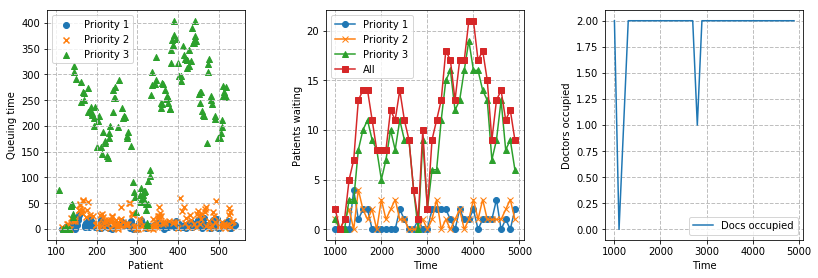

Patient-centred metrics:
------------------------

Lower quartile time in system by priority:
0.25      consult_time      q_time  system_time
priority                                       
1.0          13.592857    3.212642    20.956138
2.0          13.066020    6.691940    24.098364
3.0          13.682954  160.148202   181.604044

Median time in system by priority:
0.5       consult_time      q_time  system_time
priority                                       
1.0          18.157815    6.916571    25.707092
2.0          17.641799   13.726659    32.809277
3.0          18.385593  234.381399   254.408919

Upper quartile time in system by priority:
0.75      consult_time      q_time  system_time
priority                                       
1.0          23.386664   11.030713    30.407625
2.0          22.128445   26.464065    43.618906
3.0          24.026666  285.454629   303.178468

Maximum time in system by priority:
1         consult_time      q_time  system_time
priority             

In [17]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

class Global_vars:
    """Storage of global variables. No object instance created"""
    
    appointment_time_mean = 18
    appointment_time_sd = 7
    audit_time = []
    audit_interval = 100
    audit_patients_in_ED = []
    audit_patients_waiting = []
    audit_patients_waiting_p1 = []
    audit_patients_waiting_p2 = []
    audit_patients_waiting_p3 = []
    audit_reources_used = []
    inter_arrival_time = 10
    number_of_docs = 2
    patient_count = 0
    patients_waiting = 0
    patients_waiting_by_priority = [0, 0, 0]
    patient_queuing_results = pd.DataFrame(columns=['priority', 'q_time', 'consult_time'])
    results = pd.DataFrame()
    sim_duration = 5000
    warm_up = 1000

class Model:
    """ The model object holds the model and the methods directly relevant to the model."""
    
    def __init__(self):
        """Creates instance of SimPy model environemnt"""
        
        self.env = simpy.Environment()

    def build_audit_results(self):
        """Compiles audit results into dataframe held in Glov_vars"""
        
        Global_vars.results['time'] = Global_vars.audit_time
        
        Global_vars.results['patients in ED'] = (
            Global_vars.audit_patients_in_ED)
        
        Global_vars.results['all patients waiting'] = (
            Global_vars.audit_patients_waiting)
        
        Global_vars.results['priority 1 patients waiting'] = (
            Global_vars.audit_patients_waiting_p1)
        
        Global_vars.results['priority 2 patients waiting'] = (
            Global_vars.audit_patients_waiting_p2)
        
        Global_vars.results['priority 3 patients waiting'] = (
            Global_vars.audit_patients_waiting_p3)
        
        Global_vars.results['resources occupied'] = (
            Global_vars.audit_reources_used)

    def chart(self):
        """Plots results at end of run"""
        
        # Define figure size and defintion
        fig = plt.figure(figsize=(12, 4.5))
        # Create two charts side by side

        # Figure 1: patient level results
        ax1 = fig.add_subplot(131)  # 1 row, 3 cols, chart position 1
        x = Global_vars.patient_queuing_results.index
        # Chart loops through 3 priorites
        markers = ['o', 'x', '^']
        for priority in range(1, 4):
            x = (Global_vars.patient_queuing_results[Global_vars.patient_queuing_results
                                                     ['priority'] == priority].index)
            
            y = (Global_vars.patient_queuing_results
                 [Global_vars.patient_queuing_results['priority'] == priority]['q_time'])
            
            ax1.scatter(x, y, marker=markers[priority - 1], label='Priority ' + str(priority))
        ax1.set_xlabel('Patient')
        ax1.set_ylabel('Queuing time')
        ax1.legend()
        ax1.grid(True, which='both', lw=1, ls='--', c='.75')

        # Figure 2: ED level queuing results
        ax2 = fig.add_subplot(132)  # 1 row, 3 cols, chart position 2
        x = Global_vars.results['time']
        y1 = Global_vars.results['priority 1 patients waiting']
        y2 = Global_vars.results['priority 2 patients waiting']
        y3 = Global_vars.results['priority 3 patients waiting']
        y4 = Global_vars.results['all patients waiting']
        ax2.plot(x, y1, marker='o', label='Priority 1')
        ax2.plot(x, y2, marker='x', label='Priority 2')
        ax2.plot(x, y3, marker='^', label='Priority 3')
        ax2.plot(x, y4, marker='s', label='All')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Patients waiting')
        ax2.legend()
        ax2.grid(True, which='both', lw=1, ls='--', c='.75')

        # Figure 3: ED staff usage
        ax3 = fig.add_subplot(133)  # 1 row, 3 cols, chart position 3
        x = Global_vars.results['time']
        y = Global_vars.results['resources occupied']
        ax3.plot(x, y, label='Docs occupied')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Doctors occupied')
        ax3.legend()
        ax3.grid(True, which='both', lw=1, ls='--', c='.75')

        # Create plot
        plt.tight_layout(pad=3)
        plt.show()

    def perform_audit(self):
        """Monitors modelled ED at regular intervals (as defined by audit 
        interval in global_vars)"""

        # Delay before first aurdit if length of warm-up
        yield self.env.timeout(Global_vars.warm_up)
        # The trigger repeated audits
        while True:
            # Record time
            Global_vars.audit_time.append(self.env.now)
            # Record patients waiting by referencing global variables
            Global_vars.audit_patients_waiting.append(Global_vars.patients_waiting)
            
            (Global_vars.audit_patients_waiting_p1.append
             (Global_vars.patients_waiting_by_priority[0]))
            
            (Global_vars.audit_patients_waiting_p2.append
             (Global_vars.patients_waiting_by_priority[1]))
            
            (Global_vars.audit_patients_waiting_p3.append
             (Global_vars.patients_waiting_by_priority[2]))
            
            # Record patients waiting by asking length of dictionary of all patients 
            # (another way of doing things)
            Global_vars.audit_patients_in_ED.append(len(Patient.all_patients))
            # Record resources occupied
            Global_vars.audit_reources_used.append(self.doc_resources.docs.count)
            # Trigger next audit after interval
            yield self.env.timeout(Global_vars.audit_interval)

    def run(self):
        """Runs the model: Sets up resources, initialises model process, and starts
        running the model environment. At the end of the run raw model data is saved
        to file, and summary figure and results are displayed."""
        
        # Set up resources
        self.doc_resources = Resources(self.env, Global_vars.number_of_docs)
        # Initialise processes that will run on model run
        self.env.process(self.trigger_admissions())
        self.env.process(self.perform_audit())
        # Run
        self.env.run(until=Global_vars.sim_duration)
        
        # End of simulation run. Build and save results.
        # The saved results are the raw audit data
        Global_vars.patient_queuing_results.to_csv('patient results.csv')
        self.build_audit_results()
        Global_vars.results.to_csv('operational results.csv')
        # Plot a chart of results
        self.chart()
        # Pront text summary of results
        self.summarise()

    def see_doc(self, p):
        """Mangages waiting for doctor resorce. Records time waiting to see doc""" 
        
        with self.doc_resources.docs.request(priority=p.priority) as req:
            Global_vars.patients_waiting += 1
            # Wait for resources to become available
            yield req
            # Resources now available
            # Record queuing times in patient object and Global dataframe
            p.time_see_doc = self.env.now
            p.queuing_time = self.env.now - p.time_in
            _results = [p.priority, p.queuing_time]
            yield self.env.timeout(p.consulation_time)
            _results.append(self.env.now - p.time_see_doc)
            # Record results if warm-up complete
            if self.env.now >= Global_vars.warm_up:
                Global_vars.patient_queuing_results.loc[p.id] = _results
            # Reduce patients waiting counts
            Global_vars.patients_waiting_by_priority[p.priority - 1] -= 1
            Global_vars.patients_waiting -= 1
            # Delete patient (removal from patient dictionary removes only
            # reference to patient and Python then automatically cleans up)
            del Patient.all_patients[p.id]
            
    def summarise(self):
        """Produces displayed text summary of model run"""
        
        # For each patient calaculate time in system as time in queue + time with doc
        Global_vars.patient_queuing_results['system_time'] =  (
                Global_vars.patient_queuing_results['q_time'] +
                Global_vars.patient_queuing_results['consult_time'])
        
        # Disply results summaries
        print ('Patient-centred metrics:')
        print ('------------------------\n')
        print ('Lower quartile time in system by priority:')
        print (Global_vars.patient_queuing_results.groupby('priority').quantile(0.25))
        print ('\nMedian time in system by priority:')
        print (Global_vars.patient_queuing_results.groupby('priority').quantile(0.50))
        print ('\nUpper quartile time in system by priority:')
        print (Global_vars.patient_queuing_results.groupby('priority').quantile(0.75))
        print ('\nMaximum time in system by priority:')
        print (Global_vars.patient_queuing_results.groupby('priority').quantile(1))
        print ('\nED-centred metrics:')
        print ('------------------\n')
        print (Global_vars.results.describe())
        
    def trigger_admissions(self):
        """Produces patient arrivals. Initialises a patient object (from Patient class), 
        passes the patient over to the see_doc method, and sets the next admission
        time/event"""
        
        # While loop continues generating new patients
        while True:
            # Initialise new patient (pass environment to be used to record
            # current simulation time)
            p = Patient(self.env)
            # Add patient to dictionary of patients
            Patient.all_patients[p.id] = p
            # Pass patient to see_doc method
            self.env.process(self.see_doc(p))
            # Sample time for next asmissions
            next_admission = random.expovariate(1 / Global_vars.inter_arrival_time)
            # Schedule next admission
            yield self.env.timeout(next_admission)


class Patient:
    """Class of patient objects. The class also holds a list of all patient objects in 
    all_patients dictionary"""
        
    # The following dictionaries store patients
    all_patients = {}

    # New patient instance
    def __init__(self, env):
        Global_vars.patient_count += 1
        
        self.consulation_time = (
            random.normalvariate(Global_vars.appointment_time_mean,
                                 Global_vars.appointment_time_sd))
        
        self.consulation_time = 0 if self.consulation_time < 0 else self.consulation_time
        self.id = Global_vars.patient_count
        self.priority = random.randint(1, 3)
        self.queuing_time = 0
        self.time_in = env.now
        self.time_see_doc = 0
        self.time_out = 0
        # 1 is subtracted from priority to align priority (1-3) with zero indexed list (0-2)
        Global_vars.patients_waiting_by_priority[self.priority - 1] += 1

class Resources:
    """Resources required by processes in the model.
    Just holds doctors as the only limiting resorce"""
    
    def __init__(self, env, number_of_docs):
        self.docs = simpy.PriorityResource(env, capacity=number_of_docs)

if __name__ == '__main__':
    """Start model running"""
    model = Model() # calls method to set up model envrionment
    model.run() # calls method to run model
    